In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier , AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score , confusion_matrix , classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score,make_scorer, recall_score





In [4]:
filepath ="./dataset/telecom_churn.csv"
df=pd.read_csv(filepath)

In [5]:
df.head()


,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,0,128,1,1,2.7,1,265.1,110,89.0,9.87,10.0
1,0,107,1,1,3.7,1,161.6,123,82.0,9.78,13.7
2,0,137,1,0,0.0,0,243.4,114,52.0,6.06,12.2
3,0,84,0,0,0.0,2,299.4,71,57.0,3.10,6.6
4,0,75,0,0,0.0,3,166.7,113,41.0,7.42,10.1


In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Churn            3333 non-null   int64  
 1   AccountWeeks     3333 non-null   int64  
 2   ContractRenewal  3333 non-null   int64  
 3   DataPlan         3333 non-null   int64  
 4   DataUsage        3333 non-null   float64
 5   CustServCalls    3333 non-null   int64  
 6   DayMins          3333 non-null   float64
 7   DayCalls         3333 non-null   int64  
 8   MonthlyCharge    3333 non-null   float64
 9   OverageFee       3333 non-null   float64
 10  RoamMins         3333 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 286.6 KB


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Churn,3333.0,0.144914,0.352067,0.0,0.00,0.00,0.00,1.00
AccountWeeks,3333.0,101.064806,39.822106,1.0,74.00,101.00,127.00,243.00
ContractRenewal,3333.0,0.903090,0.295879,0.0,1.00,1.00,1.00,1.00
DataPlan,3333.0,0.276628,0.447398,0.0,0.00,0.00,1.00,1.00
DataUsage,3333.0,0.816475,1.272668,0.0,0.00,0.00,1.78,5.40
CustServCalls,3333.0,1.562856,1.315491,0.0,1.00,1.00,2.00,9.00
DayMins,3333.0,179.775098,54.467389,0.0,143.70,179.40,216.40,350.80
DayCalls,3333.0,100.435644,20.069084,0.0,87.00,101.00,114.00,165.00
MonthlyCharge,3333.0,56.305161,16.426032,14.0,45.00,53.50,66.20,111.30
OverageFee,3333.0,10.051488,2.535712,0.0,8.33,10.07,11.77,18.19


In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
df.Churn.value_counts()

Churn
0    2850
1     483
Name: count, dtype: int64

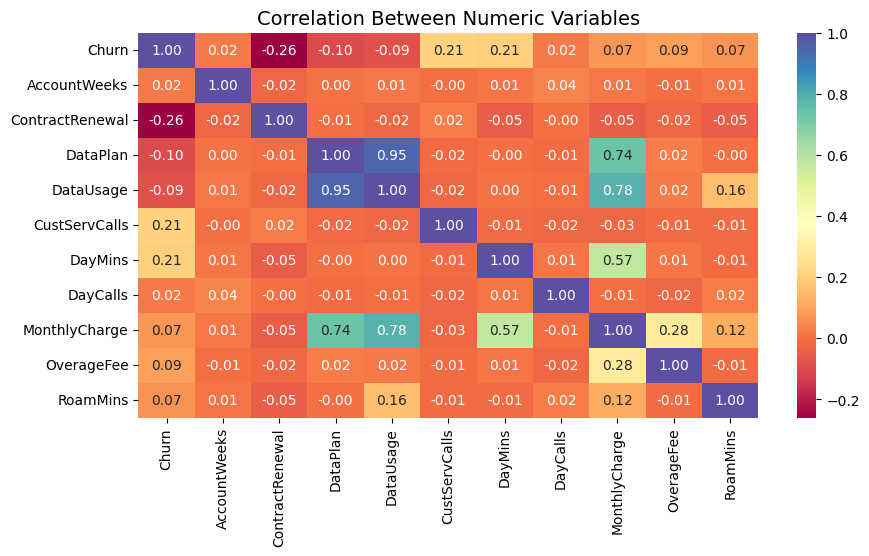

In [10]:
plt.figure(figsize=(10,5))
sns.heatmap(df.corr(),annot=True,fmt=".2f", cmap="Spectral")
plt.title("Correlation Between Numeric Variables", fontsize=14)
plt.show()

Observations:
- Based On these correlations we can observe that churn is negatively correlated with ContractRenewal, DataPlan and DataUsage which is Logical for the contract Renewal because a customer who recently renewed its contract is less likely to churn however we will do further analysis for the DataPlan and DataUsage
- Also we can observe that churn is positevly correlated with CustomerServiceCalls and Daytime minutes
- The high correlation between MonthlyCharge, DataPlan and DataUsage is pretty obvious and clear

Notes To consider:
- High MonthlyCharge + high Overagefee can cause churn (MonthlyCharge is postively correlated with overage fee)
- Customerservice calls is an important indicator for churn


<Figure size 1000x1000 with 0 Axes>

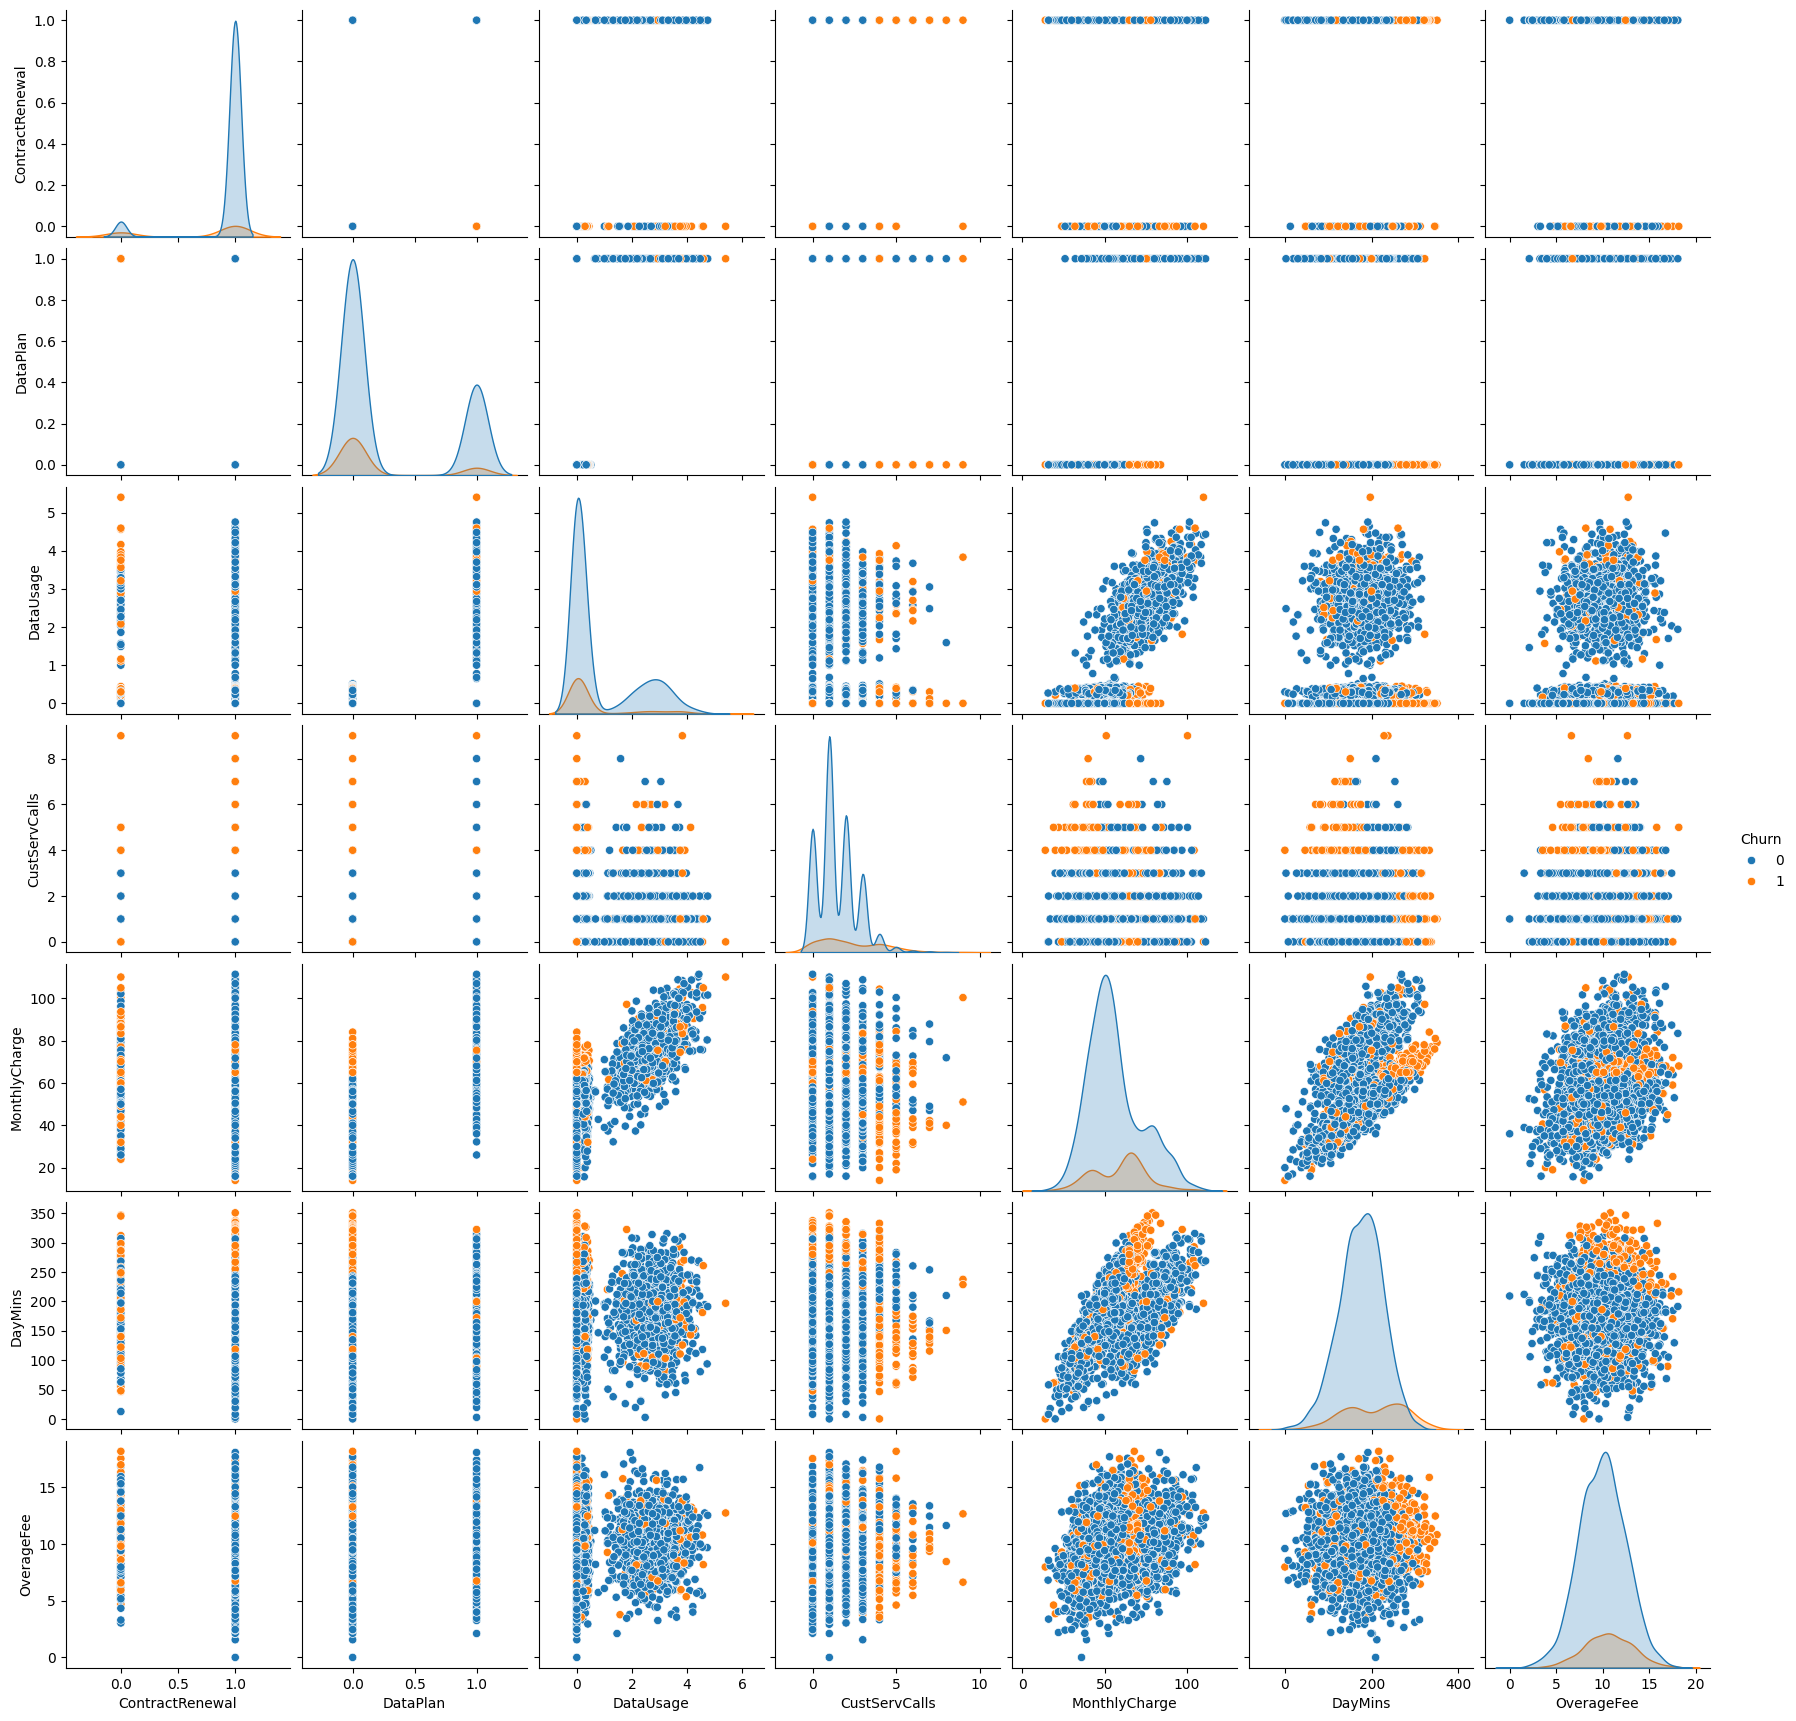

In [11]:
plt.figure(figsize=(10,10))
cols=["ContractRenewal","DataPlan","DataUsage","CustServCalls","MonthlyCharge","DayMins","OverageFee"]
sns.pairplot(data=df, vars=cols,hue="Churn")

I dont think this pairplot figure is very helpful, lets try boxplot :


In [12]:
df_categorical = df.copy()
df_categorical["Churn"] = list("Yes" if data == 1 else "No" for data in df_categorical["Churn"])
df_categorical["Churn"] = df_categorical["Churn"].astype("category")

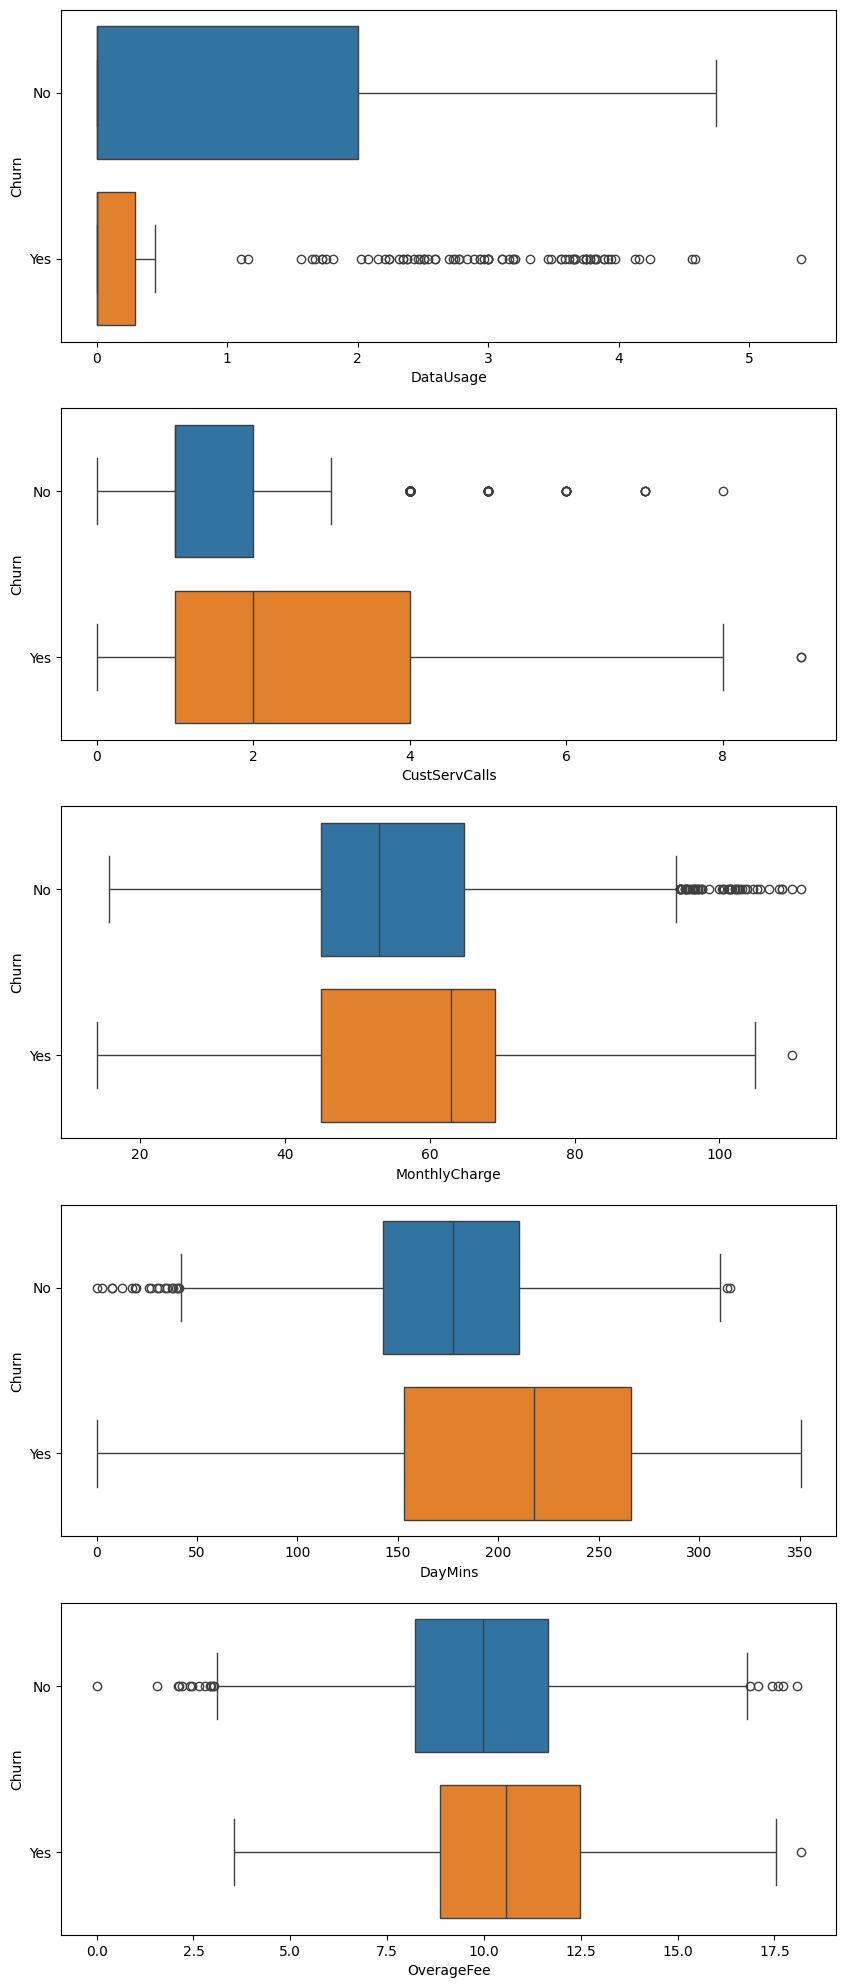

In [13]:
filtered_cols = [col for col in cols if col not in ["ContractRenewal", "DataPlan"]]

fig, ax = plt.subplots(len(filtered_cols), 1, figsize=(10,25))

for i, var in enumerate(filtered_cols):
    sns.boxplot(data=df_categorical, y="Churn", x=var, hue="Churn", ax=ax[i])

Key Observation :
Most customers who are likely to churn :
- Have 0GB of DataUsage
- Do many customer service calls
- Higher Monthly charge than others
- More daytime minutes

Lets see if the churn rate differs with and without data plan 

Text(0.5, 1.0, 'number of customers churning with and without data plan')

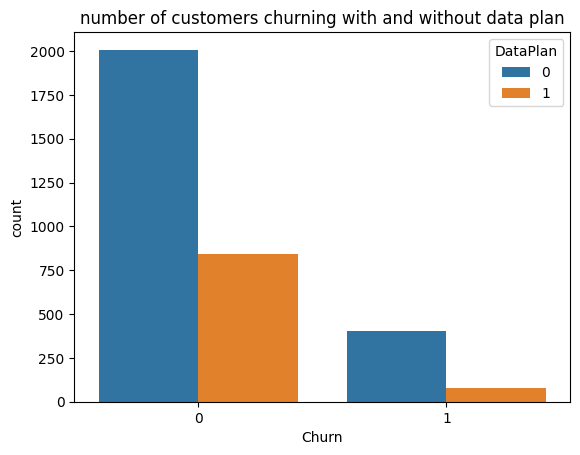

In [14]:
plan_hist = sns.countplot(data=df, x="Churn", hue="DataPlan")
plan_hist.set_title("number of customers churning with and without data plan")

In [15]:
plan_df = df[df["DataPlan"] == 1]
no_plan_df = df[df["DataPlan"] == 0]

churn_rate_plan = np.sum(plan_df["Churn"]) / len(plan_df["Churn"])
churn_rate_no_plan = np.sum(no_plan_df["Churn"]) / len(no_plan_df["Churn"])

print(f"Churn Rate for cust. with plan   :   {round(churn_rate_plan * 100, 2)}%")
print(f"Churn Rate for cust. without plan   :   {round(churn_rate_no_plan * 100, 2)}%")

Churn Rate for cust. with plan   :   8.68%
Churn Rate for cust. without plan   :   16.72%


So Churn rate is pretty much higher when customers do not have a data plan 

What about the number of service calls? After how many customer service calls the customer will more likely to churn?

Text(0.5, 1.0, 'number of customers Vs number of service calls')

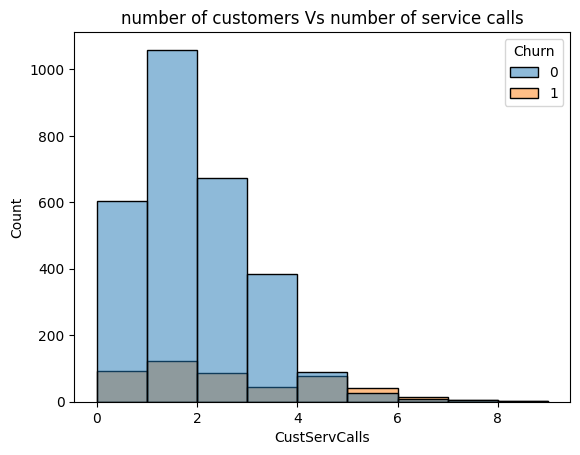

In [16]:
calls_hist = sns.histplot(data=df, x="CustServCalls", hue="Churn", binwidth=1)
calls_hist.set_title("number of customers Vs number of service calls")

Text(0.5, 1.0, 'number of customers vs number of service calls plus than 4')

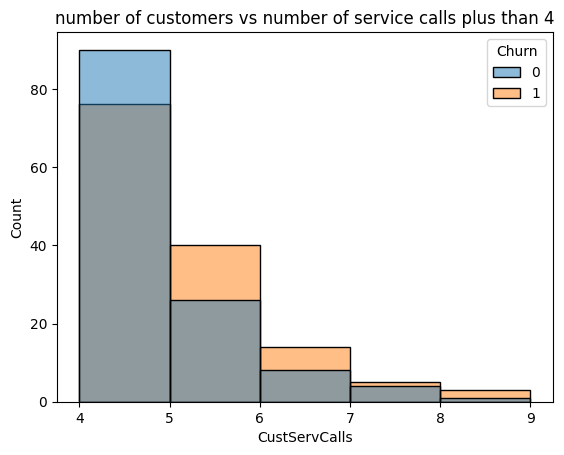

In [17]:
calls_hist_close = sns.histplot(data=df[df["CustServCalls"] >= 4],
             x="CustServCalls",
             hue="Churn",
             binwidth=1)
calls_hist_close.set_title("number of customers vs number of service calls plus than 4")

In [18]:
Custserv1_df = df[df["CustServCalls"] <4]
Custserv2_df = df[df["CustServCalls"] >4]

churn_rate1 = np.sum(Custserv1_df["Churn"]) / len(Custserv1_df["Churn"])
churn_rate2 = np.sum(Custserv2_df["Churn"]) / len(Custserv2_df["Churn"])

print(f"Churn Rate for cust. with less than 4 service calls  :   {round(churn_rate1 * 100, 2)}%")
print(f"Churn Rate for cust. with more than 4 service calls  :   {round(churn_rate2 * 100, 2)}%")

Churn Rate for cust. with less than 4 service calls  :   11.25%
Churn Rate for cust. with more than 4 service calls  :   61.39%


In [19]:
X = df.drop(['Churn'], axis=1)
y = df['Churn']

In [20]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = .22 , stratify=y, random_state = 42)


In [21]:
LRM = LogisticRegression(max_iter=1000)
RFM = RandomForestClassifier()
DTM = DecisionTreeClassifier()
SVCM = SVC()
GBC = GradientBoostingClassifier()
ABC = AdaBoostClassifier()
KNN =KNeighborsClassifier(5)

models = [LRM , RFM , DTM , SVCM , GBC , ABC,KNN]
results = {}
recall_scorer = make_scorer(recall_score, pos_label=1)
for model in models:
    print(f'The Model is {model}')
    k_folds = KFold(n_splits=5, shuffle=True, random_state=42)
    
    scores = cross_val_score(model, X_train , y_train, cv=k_folds,scoring=recall_scorer)
    
    print("K-Fold Cross-Validation Recall Scores:", scores)
    
    mean_recall = np.mean(scores)
    results[model] = mean_recall
    print("Mean Recall:", mean_recall)
    print('-------------------------')


The Model is LogisticRegression(max_iter=1000)
K-Fold Cross-Validation Recall Scores: [0.22972973 0.13095238 0.2027027  0.17948718 0.14925373]
Mean Recall: 0.1784251448430553
-------------------------
The Model is RandomForestClassifier()
K-Fold Cross-Validation Recall Scores: [0.67567568 0.55952381 0.7027027  0.66666667 0.82089552]
Mean Recall: 0.6850928753913827
-------------------------
The Model is DecisionTreeClassifier()
K-Fold Cross-Validation Recall Scores: [0.64864865 0.5952381  0.63513514 0.62820513 0.7761194 ]
Mean Recall: 0.6566692820424164
-------------------------
The Model is SVC()
K-Fold Cross-Validation Recall Scores: [0.01351351 0.02380952 0.04054054 0.01282051 0.04477612]
Mean Recall: 0.027092042017415153
-------------------------
The Model is GradientBoostingClassifier()
K-Fold Cross-Validation Recall Scores: [0.71621622 0.55952381 0.63513514 0.69230769 0.80597015]
Mean Recall: 0.6818306004873169
-------------------------
The Model is AdaBoostClassifier()
K-Fold Cro

In [22]:
best_model = max(results, key=results.get)
print(f'The best model is {best_model} with a mean accuracy of {results[best_model]}')

best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)


The best model is RandomForestClassifier() with a mean accuracy of 0.6850928753913827


In [23]:
best_model.score(X_train, y_train)

1.0

In [24]:
best_model.score(X_test, y_test)

0.9305177111716622

In [25]:
accuracy_score(y_test, y_pred_best)

0.9305177111716622

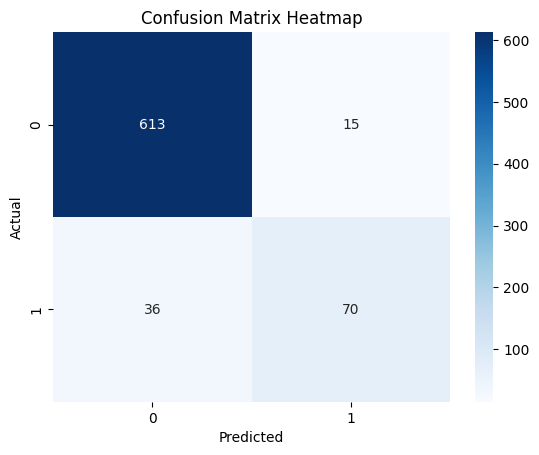

In [26]:
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()

In [27]:

precision = precision_score(y_test, y_pred_best)
recall = recall_score(y_test, y_pred_best)
f1 = f1_score(y_test, y_pred_best)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 0.8235294117647058
Recall: 0.660377358490566
F1 Score: 0.7329842931937173


In [28]:
print("Accuracy:", accuracy_score(y_test, y_pred_best))

Accuracy: 0.9305177111716622


In [29]:
results = X_test.copy()
results['Actual'] = y_test
results['Predicted'] = y_pred_best

# False Negatives
false_negatives = results[(results['Actual'] == 1) & (results['Predicted'] == 0)]

# False Positives
false_positives = results[(results['Actual'] == 0) & (results['Predicted'] == 1)]


In [30]:
false_negatives.describe()

,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins,Actual,Predicted
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.0,36.0
mean,102.333333,0.722222,0.305556,0.766667,1.583333,200.727778,103.861111,59.583333,10.226389,10.019444,1.0,0.0
std,38.941715,0.454257,0.467177,1.217832,1.079021,53.971128,18.192860,18.960598,2.470600,2.821734,0.0,0.0
min,23.000000,0.000000,0.000000,0.000000,0.000000,81.900000,73.000000,34.000000,3.770000,4.100000,1.0,0.0
25%,72.000000,0.000000,0.000000,0.000000,1.000000,166.325000,91.000000,46.500000,8.605000,8.200000,1.0,0.0
50%,107.000000,1.000000,0.000000,0.000000,1.000000,200.250000,100.500000,56.350000,10.160000,10.300000,1.0,0.0
75%,127.000000,1.000000,1.000000,1.610000,2.000000,238.750000,123.000000,65.225000,11.717500,11.450000,1.0,0.0
max,178.000000,1.000000,1.000000,3.920000,4.000000,322.400000,134.000000,104.300000,15.630000,17.300000,1.0,0.0


In [31]:
false_negatives.head()

,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins,Actual,Predicted
198,131,0,1,3.73,4,292.9,101,104.3,9.99,13.8,1,0
2681,121,1,0,0.21,0,144.8,126,44.1,10.03,13.3,1,0
3093,27,1,0,0.36,2,226.3,95,65.6,13.72,8.2,1,0
1965,139,1,0,0.00,1,236.6,109,55.0,8.50,11.1,1,0
2882,178,0,0,0.00,2,124.5,134,34.0,7.06,11.4,1,0


In [32]:
false_positives.describe()

,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins,Actual,Predicted
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.0,15.0
mean,89.666667,0.866667,0.133333,0.457333,2.133333,222.746667,100.066667,61.906667,11.096000,10.273333,0.0,1.0
std,43.271017,0.351866,0.351866,0.983401,1.641718,66.491222,25.251497,10.177389,2.362942,3.036085,0.0,0.0
min,21.000000,0.000000,0.000000,0.000000,0.000000,62.300000,67.000000,34.000000,6.370000,5.400000,0.0,1.0
25%,59.500000,1.000000,0.000000,0.000000,1.000000,194.200000,77.500000,62.000000,9.465000,8.150000,0.0,1.0
50%,86.000000,1.000000,0.000000,0.000000,1.000000,239.800000,104.000000,64.000000,12.120000,10.700000,0.0,1.0
75%,105.500000,1.000000,0.000000,0.235000,3.000000,271.200000,118.500000,65.700000,13.260000,11.850000,0.0,1.0
max,178.000000,1.000000,1.000000,3.130000,6.000000,295.300000,150.000000,74.300000,13.750000,17.000000,0.0,1.0


In [33]:
false_positives.head()

,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins,Actual,Predicted
3256,115,1,0,0.23,3,268.0,115,61.3,7.68,17.0,0,1
2130,93,1,0,0.24,1,239.8,70,65.4,12.59,10.9,0,1
412,85,1,0,0.20,0,259.8,85,67.0,12.12,5.4,0,1
2721,50,1,0,0.29,1,295.3,127,64.9,6.37,9.6,0,1
785,69,1,0,0.00,3,228.2,70,62.0,13.19,10.7,0,1


In [34]:
true_positives = results[(results['Actual'] == 1) & (results['Predicted'] == 1)]
true_negatives = results[(results['Actual'] == 0) & (results['Predicted'] == 0)]

In [35]:
results = X_test.copy()
results['Actual'] = y_test
results['Predicted'] = best_model.predict(X_test)


def get_outcome(row):
    if row['Actual'] == 1 and row['Predicted'] == 1:
        return 'TP'
    elif row['Actual'] == 0 and row['Predicted'] == 0:
        return 'TN'
    elif row['Actual'] == 1 and row['Predicted'] == 0:
        return 'FN'
    else:
        return 'FP'


results['PredictionType'] = results.apply(get_outcome, axis=1)

In [36]:
importances = best_model.feature_importances_


feature_names = X_train.columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})


feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)


print(feat_imp_df.head(10))

           Feature  Importance
5          DayMins    0.204383
7    MonthlyCharge    0.165754
4    CustServCalls    0.145429
8       OverageFee    0.094799
9         RoamMins    0.082997
3        DataUsage    0.073891
1  ContractRenewal    0.072252
6         DayCalls    0.063289
0     AccountWeeks    0.062242
2         DataPlan    0.034965


/var/folders/sx/ch1z2wcs05l7n6_3cb6xkh680000gn/T/ipykernel_3282/1340089855.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(10), palette='viridis')


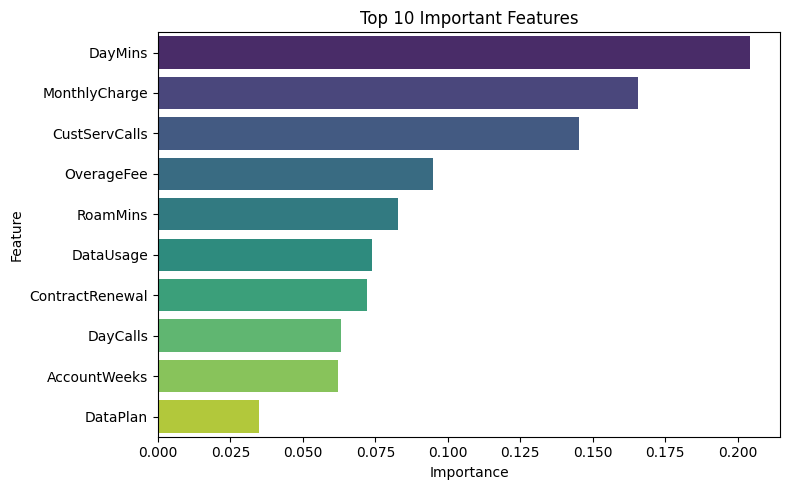

In [37]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(10), palette='viridis')
plt.title('Top 10 Important Features')
plt.tight_layout()
plt.show()


In [38]:
top_features = feat_imp_df['Feature'].head(4).tolist()  
top_features.append('PredictionType')  
pairplot_data = results[top_features]

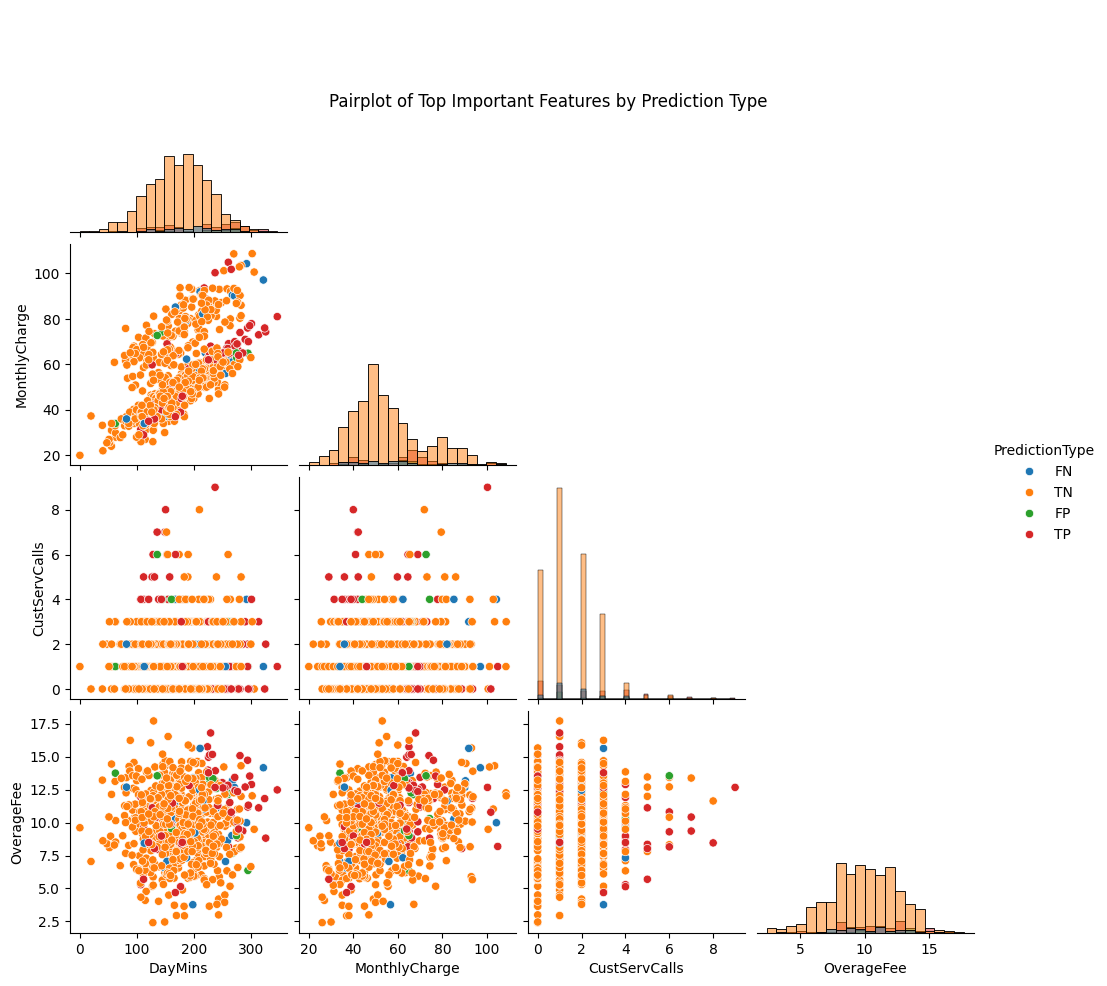

In [39]:
sns.pairplot(data=pairplot_data, hue='PredictionType', diag_kind='hist', corner=True)
plt.suptitle("Pairplot of Top Important Features by Prediction Type", y=0.9)
plt.show()


<Axes: xlabel='CustServCalls', ylabel='Count'>

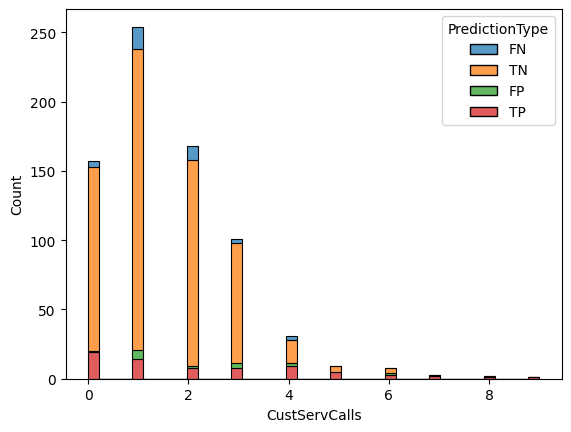

In [40]:
sns.histplot(data=results, x='CustServCalls', hue='PredictionType', multiple='stack')


<Axes: xlabel='MonthlyCharge', ylabel='Count'>

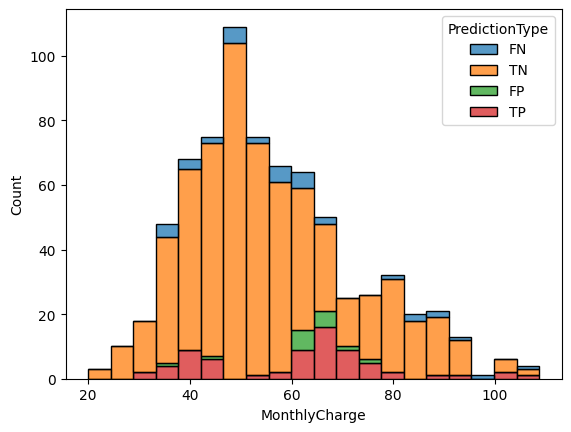

In [41]:
sns.histplot(data=results, x='MonthlyCharge', hue='PredictionType', multiple='stack')

<Axes: xlabel='DayMins', ylabel='Count'>

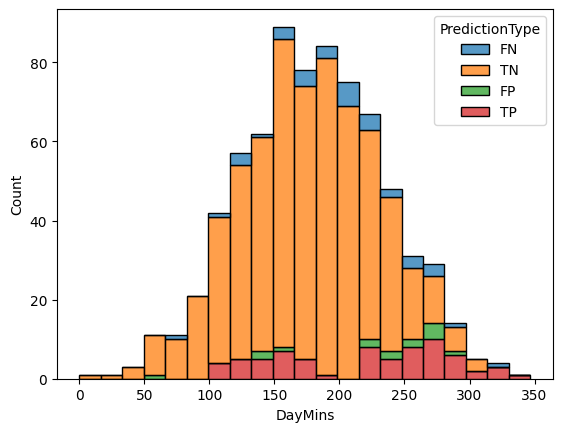

In [42]:
sns.histplot(data=results, x='DayMins', hue='PredictionType', multiple='stack')

<Axes: xlabel='OverageFee', ylabel='Count'>

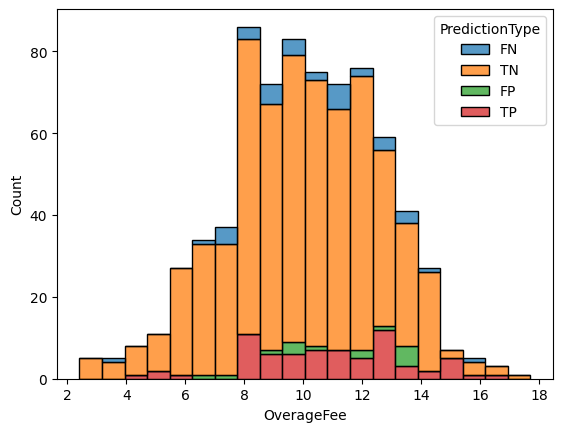

In [43]:
sns.histplot(data=results, x='OverageFee', hue='PredictionType', multiple='stack')

In [44]:
y_proba = best_model.predict_proba(X_test)[:, 1]

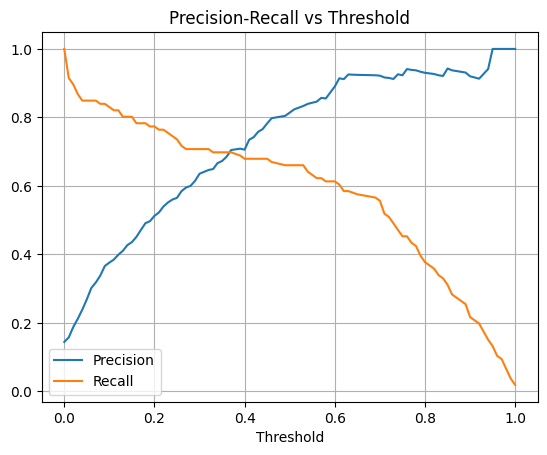

In [45]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.legend()
plt.title("Precision-Recall vs Threshold")
plt.grid()
plt.show()

In [46]:

y_pred_new = (y_proba >0.25).astype(int) 

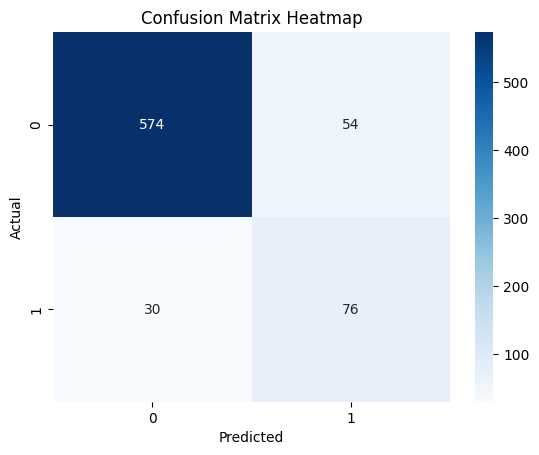

In [47]:
sns.heatmap(confusion_matrix(y_test, y_pred_new), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()

In [48]:

precision = precision_score(y_test, y_pred_new)
recall = recall_score(y_test, y_pred_new)
f1 = f1_score(y_test, y_pred_new)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 0.5846153846153846
Recall: 0.7169811320754716
F1 Score: 0.6440677966101694


In [49]:

results = {
    "y_pred_new (modified threshold)": recall_score(y_test, y_pred_new),
    "y_pred_best (original)": recall_score(y_test, y_pred_best)
}


best_model_name = max(results, key=results.get)
best_recall = results[best_model_name]

print(f"The best recall score is {best_recall:.4f} from: {best_model_name}")


The best recall score is 0.7170 from: y_pred_new (modified threshold)


In [50]:
import joblib

In [51]:
joblib.dump(best_model, 'model_churn.pkl')

['model_churn.pkl']